# Scaling Both 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import json
from tqdm import tqdm
import seaborn as sns
sns.set_theme()
sns.set(font_scale=0.8)

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

import sys
sys.path.append('/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/tests/fixtures/signal_decompositions/')
from utils import plot_decomp, plot_signal
import cvxpy as cvx

np.random.seed(12) 

In [2]:
%load_ext autoreload
%autoreload 2

# Create data

In [3]:
# create mix of piecewise fns
# create mix of sinusoids data
ws = [165, 660, 330]
period = 660

t = np.arange(period*15)
X_real = np.zeros((4, len(t)), dtype=float)

for i in range(3):
    w = ws[i]
    X_real[i] = signal.square(2 * np.pi * t / w)  

# noise
X_real[3] = 0.15 * np.random.randn(len(t))

signal_large = np.sum(X_real, axis=0)

# for reference
gt = np.sum(X_real[:3], axis=0)

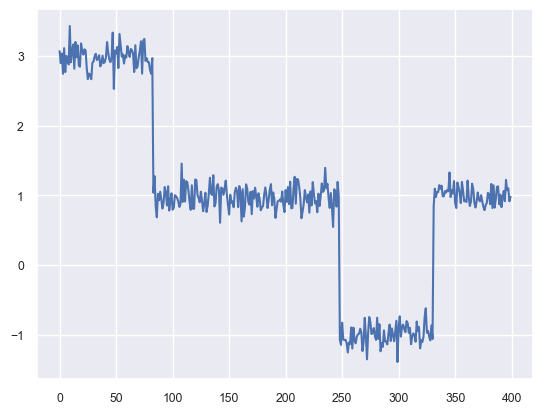

In [4]:
plt.plot(signal_large[:400]);

In [5]:
signal_small = signal_large[:period*1]
signal_medium = signal_large[:period*5]

# Define SD problem

In [6]:
def l2_l1d1_periodic(
    signal,
    weight,
    periodic,
    l2="norm", # or "sumsquares"
    scale=False,
    period=period, 
    solver="MOSEK"
):
    l2_func = {"norm" : cvx.norm,
               "sumsquares" : cvx.sum_squares
              }
    
    scale_err = 1/len(signal) if scale else 1
    scale_hat = 1/(len(signal)-1) if scale else 1
    
    s_hat = cvx.Variable(len(signal))
    s_error = cvx.Variable(len(signal))
    weight = cvx.Constant(value=weight)
    scale_err = cvx.Constant(value=scale_err)
    scale_hat = cvx.Constant(value=scale_hat)
    
    objective = cvx.Minimize(
       scale_err * l2_func[l2](s_error)
      + weight *  scale_hat * cvx.norm1(cvx.diff(s_hat, k=1))
    )

    # Consistency and periodicity constraints
    constraints = [
        signal == s_hat + s_error
    ]
    if periodic and len(signal)>period:
        constraints.append(s_hat[period:] - s_hat[:-period] == 0)
        
    problem = cvx.Problem(objective=objective, constraints=constraints)
    problem.solve(solver=solver)
    
    return s_hat.value, s_error.value, problem.objective.value

# Run comparison

In [21]:
results = {}
# weights for periodic=True
weight_iter_unscaled = np.logspace(-0.5, 0.5, 100)
weight_iter_scaled = np.logspace(-0.5, 0.3, 100)

# weights for periodic=False
# weight_iter_unscaled = np.logspace(-0.5, 0.5, 100)
# weight_iter_scaled = np.logspace(-4, -2, 100)

In [22]:
def run(sig, run_type, scale, periodic):
    results[run_type] = {}
    weight_iter = weight_iter_scaled if scale else weight_iter_unscaled

    # results with sum_squares
    mae_s_hat_list = []
    for w in tqdm(weight_iter):
        s_hat_ss, s_err_ss, _ = l2_l1d1_periodic(sig, weight=w, l2="sumsquares", scale=scale, periodic=periodic)
        mae_s_hat_list.append(mae(np.sum(X_real[:3], axis=0)[:len(sig)], s_hat_ss))
        
    results[run_type]["weight_min"] =  weight_iter[np.argmin(mae_s_hat_list)]
    results[run_type]["mae_s_hat_list"] = mae_s_hat_list

In [23]:
# Small len without scaling
run(signal_small, "Small Len.", scale=False, periodic=True)

# Medium len without scaling
run(signal_medium, "Med. Len.", scale=False, periodic=True)

# Large len without scaling
run(signal_large, "Large Len.", scale=False, periodic=True)

# Small len with scaling
run(signal_small, "Small Len. Scaled", scale=True, periodic=True)

# Medium len with scaling
run(signal_medium, "Med. Len. Scaled", scale=True, periodic=True)

# Large len with scaling
run(signal_large, "Large Len. Scaled", scale=True, periodic=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.43it/s]


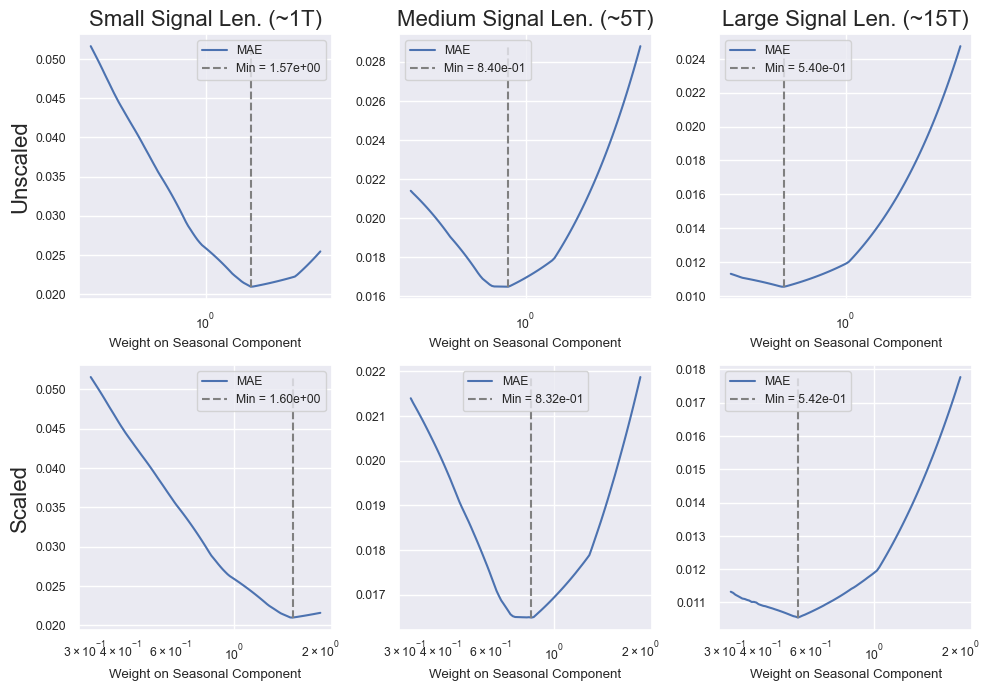

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, figsize=(10,7))

res_k = list(results.keys())

for ax_ in ax:
    for ax__, k in zip(ax_, res_k):
        weight_iter = weight_iter_unscaled if k in list(results.keys())[:3] else weight_iter_scaled
        ax__.plot(weight_iter, results[k]["mae_s_hat_list"], label="MAE")
        ax__.vlines(results[k]["weight_min"], min(results[k]["mae_s_hat_list"]), max(results[k]["mae_s_hat_list"]), label=f'Min = {results[k]["weight_min"]:.2e}',
                linestyle="--", color="gray")
        ax__.legend()
    res_k = res_k[3:]
        
ax[0][0].set_ylabel(r"Unscaled", fontsize=16)
ax[1][0].set_ylabel("Scaled", fontsize=16)
ax[0][0].set_title("Small Signal Len. (~1T)", fontsize=16)
ax[0][1].set_title("Medium Signal Len. (~5T)", fontsize=16)
ax[0][2].set_title("Large Signal Len. (~15T)", fontsize=16)

for ax_ in ax[1]:
    ax_.set_xlabel("Weight on Seasonal Component")
    ax_.set_xscale("log")
for ax_ in ax[0]:
    ax_.set_xlabel("Weight on Seasonal Component")
    ax_.set_xscale("log")

plt.tight_layout()

In [26]:
periodicity = True

# unscaled
weight_unscaled = results["Small Len."]["weight_min"]
results["sm_unsc_hat_min_w"] = weight_unscaled
results["sm_unsc_hat_min"], _, _ = l2_l1d1_periodic(signal_small,
                                                                                     weight=weight_unscaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=False, periodic=periodicity)
weight_unscaled = results["Med. Len."]["weight_min"]
results["md_unsc_hat_min_w"] = weight_unscaled
results["md_unsc_hat_min"], _, _ = l2_l1d1_periodic(signal_medium,
                                                                                     weight=weight_unscaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=False, periodic=periodicity)
weight_unscaled = results["Large Len."]["weight_min"]
results["lg_unsc_hat_min_w"] = weight_unscaled
results["lg_unsc_hat_min"], _, _ = l2_l1d1_periodic(signal_large,
                                                                                     weight=weight_unscaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=False, periodic=periodicity)

                 
# scaled
weight_scaled = results["Small Len. Scaled"]["weight_min"]
results["sm_sc_hat_min_w"] = weight_scaled
results["sm_sc_hat_min"], _, _ = l2_l1d1_periodic(signal_small,
                                                                                     weight=weight_scaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=True, periodic=periodicity)
weight_scaled = results["Med. Len. Scaled"]["weight_min"]
results["md_sc_hat_min_w"] = weight_scaled
results["md_sc_hat_min"], _, _ = l2_l1d1_periodic(signal_medium,
                                                                                     weight=weight_scaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=True, periodic=periodicity)
weight_scaled = results["Large Len. Scaled"]["weight_min"]
results["lg_sc_hat_min_w"] = weight_scaled
results["lg_sc_hat_min"], _, _ = l2_l1d1_periodic(signal_large,
                                                                                     weight=weight_scaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=True, periodic=periodicity)
                 

In [27]:
runs = ['Small Len.', 'Med. Len.', 'Large Len.', 'Small Len. Scaled', 'Med. Len. Scaled', 'Large Len. Scaled']
periodicity = True

# unscaled, weight = 8.86e-1
weight_unscaled =  8.4e-1 # 1.65 #

results["sm_unsc_hat"], _, _ = l2_l1d1_periodic(signal_small,
                                                                                     weight=weight_unscaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=False, periodic=periodicity)

results["md_unsc_hat"], _, _ = l2_l1d1_periodic(signal_medium,
                                                                                     weight=weight_unscaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=False, periodic=periodicity)

results["lg_unsc_hat"], _, _ = l2_l1d1_periodic(signal_large,
                                                                                     weight=weight_unscaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=False, periodic=periodicity)

                 
# scaled, weight = 1.83e-4
weight_scaled = 8.32e-1 # 4.86e-4 # 2.73e3 # 5.5e3

results["sm_sc_hat"], _, _ = l2_l1d1_periodic(signal_small,
                                                                                     weight=weight_scaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=True, periodic=periodicity)

results["md_sc_hat"], _, _ = l2_l1d1_periodic(signal_medium,
                                                                                     weight=weight_scaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=True, periodic=periodicity)

results["lg_sc_hat"], _, _ = l2_l1d1_periodic(signal_large,
                                                                                     weight=weight_scaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=True, periodic=periodicity)
                 

sm_unsc_hat_min
md_unsc_hat_min
lg_unsc_hat_min
sm_sc_hat_min
md_sc_hat_min
lg_sc_hat_min


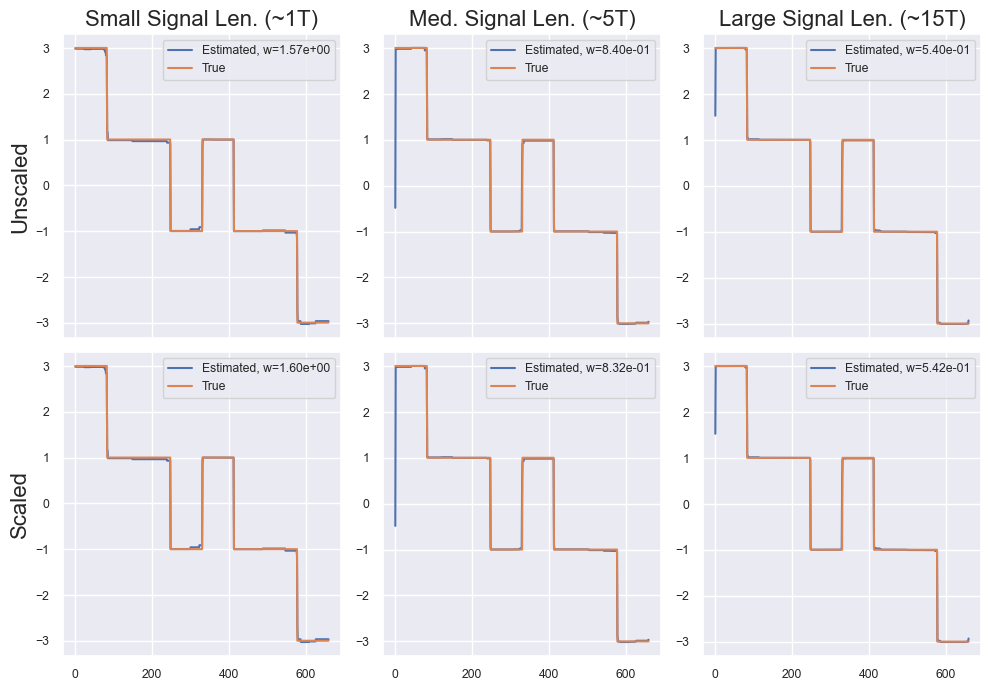

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(10,7))
res_k = ["sm_unsc_hat_min", "md_unsc_hat_min", "lg_unsc_hat_min", "sm_sc_hat_min", "md_sc_hat_min", "lg_sc_hat_min"]

for ax_ in ax:
    for ax__, k in zip(ax_, res_k):
        print(k)
        ax__.plot(results[k][:period], label=f"Estimated, w={results[k+'_w']:.2e}")
        ax__.plot(gt[:period], label="True")
        ax__.legend()
    res_k = res_k[3:]
        
ax[0][0].set_ylabel(f"Unscaled", fontsize=16)
ax[1][0].set_ylabel(f"Scaled", fontsize=16)
ax[0][0].set_title("Small Signal Len. (~1T)", fontsize=16)
ax[0][1].set_title("Med. Signal Len. (~5T)", fontsize=16)
ax[0][2].set_title("Large Signal Len. (~15T)", fontsize=16)

plt.tight_layout()

sm_unsc_hat
md_unsc_hat
lg_unsc_hat
sm_sc_hat
md_sc_hat
lg_sc_hat


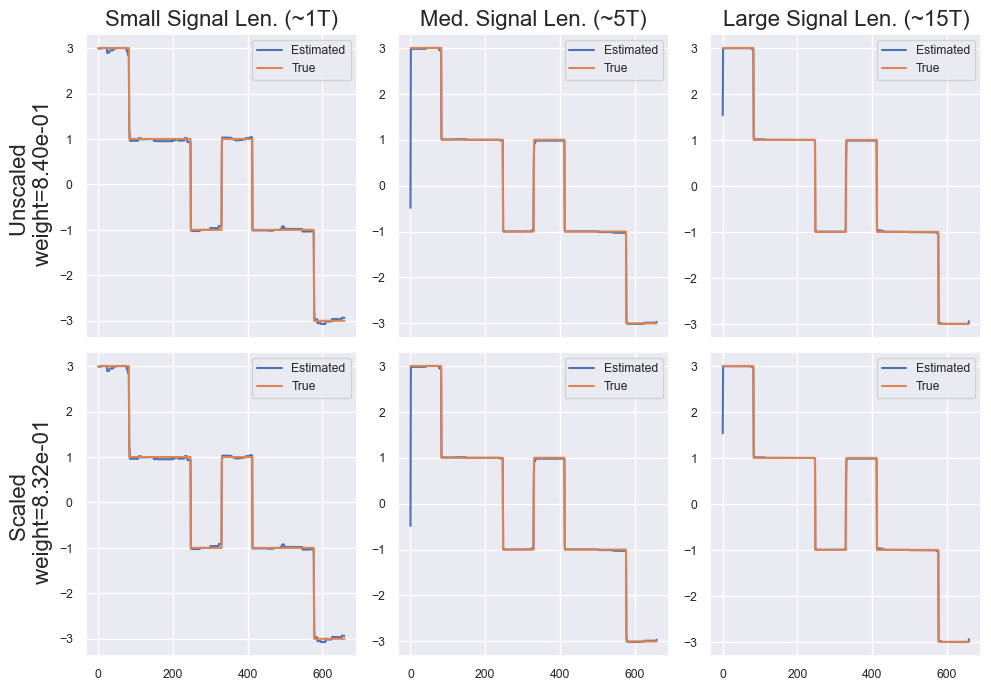

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(10,7))
res_k = ["sm_unsc_hat", "md_unsc_hat", "lg_unsc_hat", "sm_sc_hat", "md_sc_hat", "lg_sc_hat"]

for ax_ in ax:
    for ax__, k in zip(ax_, res_k):
        print(k)
        ax__.plot(results[k][:period], label="Estimated")
        ax__.plot(gt[:period], label="True")
        ax__.legend()
    res_k = res_k[3:]
        
ax[0][0].set_ylabel(f"Unscaled \n weight={weight_unscaled:.2e}", fontsize=16)
ax[1][0].set_ylabel(f"Scaled \n weight={weight_scaled:.2e}", fontsize=16)
ax[0][0].set_title("Small Signal Len. (~1T)", fontsize=16)
ax[0][1].set_title("Med. Signal Len. (~5T)", fontsize=16)
ax[0][2].set_title("Large Signal Len. (~15T)", fontsize=16)

plt.tight_layout()